### (Setup - start by installing and importing the Python SDK.)

In [1]:
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.9 MB/s eta 0:

In [2]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

## **1. RAG**

### 1.1 Reading the pdf document and split into chunks

In [4]:
import os
from pypdf import PdfReader
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry
from langchain.text_splitter import RecursiveCharacterTextSplitter 


pdf_path = '/kaggle/input/recursion-exscientia/recursion-and-exscientia-two-leaders-in-the-ai.pdf'  

def extract_text_from_pdf(pdf_path):
    pdf = PdfReader(pdf_path)
    text = ""
    for page in pdf.pages:  # Use pdf.pages instead of pdf
        text += page.extract_text()
    return text

# Extract text
pdf_text = extract_text_from_pdf(pdf_path)

# Split text into chunks for RAG
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600,
    chunk_overlap=100
)
chunks = text_splitter.split_text(pdf_text)



### 1.2 Creating the embedding database

In [5]:
import sqlite3
from sentence_transformers import SentenceTransformer

# Load multilingual embedding model (E5-small model)
model = SentenceTransformer('intfloat/multilingual-e5-small')

# Database setup (SQLite for simplicity)
conn = sqlite3.connect('embeddings.db')
cursor = conn.cursor()
cursor.execute('''CREATE TABLE IF NOT EXISTS embeddings
              (chunk_id INTEGER PRIMARY KEY, text_chunk TEXT, embedding BLOB)''') #BLOB (Binary Large Object)
conn.commit()

# Function to embed chunks and store in the database
def embed_and_store_chunks(chunks):
    for i, chunk in enumerate(chunks):
        embedding = model.encode(chunk)
        # Store embedding and chunk in the database (BLOB format for embedding)
        cursor.execute("INSERT INTO embeddings (text_chunk, embedding) VALUES (?, ?)",
                       (chunk, embedding.tobytes()))
    conn.commit()

embed_and_store_chunks(chunks)

2025-04-16 19:35:23.303375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744832123.570140      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744832123.647641      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### 1.3 Retrive the most relavant chunks

In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

def retrieve_relevant_chunks(query, top_n=5):
    # Encode the query
    query_embedding = model.encode(query)

    # Normalize the query embedding
    query_embedding = normalize([query_embedding])[0]

    # Retrieve all embeddings from the database
    cursor.execute("SELECT text_chunk, embedding FROM embeddings")
    all_embeddings = cursor.fetchall()

    similarities = []
    for text_chunk, embedding in all_embeddings:
        embedding_np = np.frombuffer(embedding, dtype=np.float32)
        # Normalize the chunk embedding
        embedding_np = normalize([embedding_np])[0]
        similarity = cosine_similarity([query_embedding], [embedding_np])[0][0]
        similarities.append((similarity, text_chunk))

    similarities.sort(reverse=True, key=lambda x: x[0])
    return [chunk for _, chunk in similarities[:top_n]]


user_query = "Based on provided documents, brief the updated pipeline in Recursion"
relevant_chunks = retrieve_relevant_chunks(user_query)

print(relevant_chunks)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

["Recursion. “With our combined strength of real-world proprietary data and the models we’ve\ncreated – hypothesizing, testing and learning in a continuous loop – we're rede\x00ning the space by\nshrinking timelines and costs, identifying and optimizing lead candidates faster than traditional\nmethods.”\nThe Company is pleased to share updates on the combined entity’s pipeline, partnerships, and\nplatform below:\nPipeline\nThe combined pipeline represents more than 10 clinical and preclinical programs. In addition there\nare approximately 10 advanced discovery programs in the current pipeline.", '82356a3682ac\nAttachments:\nRecursion’s Pipeline of Programs\nRecursion’s Partnership\nThe RecursionOS Platform', 'advisor roles for the combined company. All three have provided many years of dedicated\nservice to the Company and we wish to express our heartfelt gratitude for each of them.\nRecursion would not be where it is today without their dedication and efforts.\nUpdate Call Information

 ### 1.4 Generate a response using LLM with the retrieved context

In [7]:
# Import the Google Generative AI library
import google.generativeai as generativeai

def generate_gemini_response(query, relevant_chunks):

    
    # Combine the relevant chunks to form the context
    context = "\n".join(relevant_chunks)
    prompt = f"Based on the following context:\n\n{context}\n\nAnswer the query: {query}"
    
    # Configure the Gemini API (you'll need your API key)
    generativeai.configure(api_key=GOOGLE_API_KEY)
    
    # Initialize the model
    model = generativeai.GenerativeModel('gemini-2.0-flash')
    
    # Generate content using Gemini
    response = model.generate_content(
        contents=[
            {"role": "user", "parts": [prompt]}
        ],
        generation_config={
            "max_output_tokens": 500,
            "temperature": 0.7
        }
    )
    
    return response.text

response = generate_gemini_response(user_query, relevant_chunks)
print (response)

The combined pipeline of Recursion and Exscientia represents more than 10 clinical and preclinical programs. Additionally, there are approximately 10 advanced discovery programs in the current pipeline.



## **2. Prompting**

In [8]:
from google.api_core import retry

# Initialize Gemini client


client = genai.Client(api_key=GOOGLE_API_KEY)

few_shot_prompt = """You are a deal searching tool, search the real pharma/biotech licensing in/out deals, M&A deals and strategic collaboration announcement based on user requests; Fierce Pharma and BioSpace are good websites to track deals
Then you parse deal stakeholders, date, deal amount, indication, medication (or drug) into valid JSON. The deal type should be one of 'licensing', 'm&a' and 'collaboration'. Do not show other system information. 
Example:
Give me 3 striking deals in licensing, M&A and collaboration
JSON Response:
    [{
        "deal_type": "licensing",
        "companies": ["AstraZeneca", "Daiichi Sankyo"],
        "date": "2023-07-15",
        "upfront": "$1 billion",
        "total_deal_value":"6.9 billion",
        "therapeutic": "oncology",
        "indication": "Advanced non-small cell lung cancer",
        "asset": "DS-1062 (trastuzumab deruxtecan)",
        "countries": ["UK", "Japan"],
        "deal_details": "AstraZeneca licensed global rights to Daiichi Sankyo's antibody-drug conjugate for multiple cancer types."
    },
    {
        "deal_type": "m&a",
        "companies": ["Pfizer", "Seagen"],
        "date": "2023-03-12",
        "upfront": "$5 billion",
        "total_deal_value": "$43 billion",
        "therapeutic": "oncology",
        "indication": "N/A",
        "asset": "Multiple ADC technologies",
        "countries": ["US", "N/A"],
        "deal_details": "Pfizer acquired Seagen to enhance its cancer therapy portfolio with antibody-drug conjugate technology."
    },
    {
        "deal_type": "collaboration",
        "companies": ["Moderna", "Merck"],
        "date": "2023-05-02",
        "amount": "$250 million upfront",
        "total_deal_value": "N/A",
        "therapeutic": "immuno-oncology",
        "indication": "Stage III/IV Melanoma",
        "asset": "mRNA-4157",
        "countries": ["US", "US"],
        "deal_details": "Strategic collaboration to develop and commercialize personalized cancer vaccines using mRNA technology."
    }]
    """

In [9]:
user_input='List up to 20 top deals occurred in 2023~2024' 
response = client.models.generate_content(
    model="gemini-2.0-flash",
    contents=[few_shot_prompt, user_input])

print(response.text)

```json
[
    {
        "deal_type": "m&a",
        "companies": ["Pfizer", "Seagen"],
        "date": "2023-03-13",
        "upfront": "N/A",
        "total_deal_value": "$43 billion",
        "therapeutic": "Oncology",
        "indication": "Various Cancers",
        "asset": "Antibody-Drug Conjugates (ADCs)",
        "countries": ["US"],
        "deal_details": "Pfizer acquired Seagen to expand its oncology portfolio, particularly in ADCs."
    },
    {
        "deal_type": "licensing",
        "companies": ["AstraZeneca", "Eccogene"],
        "date": "2024-05-22",
        "upfront": "$185 million",
        "total_deal_value": "Up to $1.825 billion",
        "therapeutic": "Metabolic Disease",
        "indication": "Obesity and Type 2 Diabetes",
        "asset": "ECC5004",
        "countries": ["China", "Global excl. China"],
        "deal_details": "AstraZeneca licensed exclusive rights to develop and commercialize Eccogene's oral GLP-1RA, ECC5004, outside of Greater China."
    },

### 2.1 Load the response to local database

In [10]:
%load_ext sql
%sql sqlite:///pharma_deals.db 

In [11]:
import sqlite3
import pandas as pd
from datetime import datetime
import json
import re


# The LLM response now contains a JSON array
response_text = response.text

# Clean up the response text
# Remove any markdown code block markers if present
cleaned_text = re.sub(r'```language=json|```json|```|language=json', '', response_text)
# Remove any leading/trailing whitespace
cleaned_text = cleaned_text.strip()

try:
    deals = json.loads(cleaned_text)
except json.JSONDecodeError:
    # If the response isn't valid JSON, we need to handle it differently
    print("Response is not valid JSON. Using raw text.")
    deals = [{"deal_text": response.text}]
print(deals)


[{'deal_type': 'm&a', 'companies': ['Pfizer', 'Seagen'], 'date': '2023-03-13', 'upfront': 'N/A', 'total_deal_value': '$43 billion', 'therapeutic': 'Oncology', 'indication': 'Various Cancers', 'asset': 'Antibody-Drug Conjugates (ADCs)', 'countries': ['US'], 'deal_details': 'Pfizer acquired Seagen to expand its oncology portfolio, particularly in ADCs.'}, {'deal_type': 'licensing', 'companies': ['AstraZeneca', 'Eccogene'], 'date': '2024-05-22', 'upfront': '$185 million', 'total_deal_value': 'Up to $1.825 billion', 'therapeutic': 'Metabolic Disease', 'indication': 'Obesity and Type 2 Diabetes', 'asset': 'ECC5004', 'countries': ['China', 'Global excl. China'], 'deal_details': "AstraZeneca licensed exclusive rights to develop and commercialize Eccogene's oral GLP-1RA, ECC5004, outside of Greater China."}, {'deal_type': 'licensing', 'companies': ['Merck', 'Dainippon Sumitomo Pharma'], 'date': '2024-05-21', 'upfront': 'N/A', 'total_deal_value': 'Up to $576 million', 'therapeutic': 'Psychiatry

In [12]:
# Create a connection to the SQLite database
conn = sqlite3.connect('pharma_deals.db')
cursor = conn.cursor()

# Drop existing tables if they exist
cursor.execute("DROP TABLE IF EXISTS licensing")
cursor.execute("DROP TABLE IF EXISTS ma")
cursor.execute("DROP TABLE IF EXISTS collab")

# Check if the deals table exists and get its column information
cursor.execute("PRAGMA table_info(deals)")
columns = cursor.fetchall()
column_names = [column[1] for column in columns]
print(f"Existing columns in deals table: {column_names}")

# Create table for deals if it doesn't exist or was dropped
if not columns:
    cursor.execute('''
    CREATE TABLE licensing (
        deal_id INTEGER PRIMARY KEY,
        deal_type TEXT,
        company_1 TEXT,
        company_2 TEXT,
        date TEXT,
        upfront TEXT,
        total_deal_value TEXT,
        indication TEXT,
        therapeutic_area TEXT,
        asset TEXT,
        country_1 TEXT,
        country_2 TEXT,
        deal_details TEXT
    )
    ''')

    cursor.execute('''
    CREATE TABLE ma (
        deal_id INTEGER PRIMARY KEY,
        deal_type TEXT,
        company_1 TEXT,
        company_2 TEXT,
        date TEXT,
        upfront TEXT,
        total_deal_value TEXT,
        indication TEXT,
        therapeutic_area TEXT,
        asset TEXT,
        country_1 TEXT,
        country_2 TEXT,
        deal_details TEXT
    )
    ''')

    cursor.execute('''
    CREATE TABLE collab (
        deal_id INTEGER PRIMARY KEY,
        deal_type TEXT,
        company_1 TEXT,
        company_2 TEXT,
        date TEXT,
        total_deal_value TEXT,
        indication TEXT,
        therapeutic_area TEXT,
        asset TEXT,
        country_1 TEXT,
        country_2 TEXT,
        deal_details TEXT
    )
    ''')
    print("Created new deals table in this session")

Existing columns in deals table: []
Created new deals table in this session


### 2.2 Insert Deals into the database

In [13]:
for deal in deals:
    # For simplicity, assuming first company is licensor/acquirer and second is licensee/target
    deal_type = deal.get('deal_type', '').lower()
    company_1 = deal['companies'][0] if len(deal['companies']) > 0 else None
    company_2 = deal['companies'][1] if len(deal['companies']) > 1 else None
    country_1 = deal['countries'][0] if len(deal['countries']) > 0 else None
    country_2 = deal['countries'][1] if len(deal['countries']) > 1 else None
  
    
# Insert into appropriate table based on deal_type
    if deal_type == 'licensing':
        cursor.execute('''
        INSERT INTO licensing (company_1, company_2, country_1, country_2, date, upfront, total_deal_value, indication, therapeutic_area, asset, deal_details)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            company_1,
            company_2,
            country_1,
            country_2,
            deal.get('date', ''),
            deal.get('upfront', ''),
            deal.get('total_deal_value', ''),
            deal.get('indication', ''),
            deal.get('therapeutic', ''),
            deal.get('asset', ''),
            deal.get('deal_details', '') 
        ))
        
    elif deal_type == 'm&a':
        cursor.execute('''
        INSERT INTO ma (company_1, company_2, country_1, country_2, date, upfront, total_deal_value, indication, therapeutic_area, asset, deal_details)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            company_1,
            company_2,
            country_1,
            country_2,
            deal.get('date', ''),
            deal.get('upfront', ''),
            deal.get('total_deal_value', ''),
            deal.get('indication', ''),
            deal.get('therapeutic', ''),
            deal.get('asset', ''),
            deal.get('deal_details', '') 
        ))
        
        
    elif deal_type == 'collaboration':
        cursor.execute('''
        INSERT INTO collab (company_1, company_2, country_1, country_2, date, total_deal_value, indication, therapeutic_area, asset, deal_details)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            company_1,
            company_2,
            country_1,
            country_2,
            deal.get('date', ''),
            deal.get('total_deal_value', ''),
            deal.get('indication', ''),
            deal.get('therapeutic', ''),
            deal.get('asset', ''),
            deal.get('deal_details', '') 
        ))
        
# Commit the changes
conn.commit()

In [14]:
# Verify the data was inserted correctly
print("Deals in the database:")
for row in conn.execute("SELECT * FROM licensing"): # select either 'licensing', 'ma' or 'collab'
    print(row)

Deals in the database:
(1, None, 'AstraZeneca', 'Eccogene', '2024-05-22', '$185 million', 'Up to $1.825 billion', 'Obesity and Type 2 Diabetes', 'Metabolic Disease', 'ECC5004', 'China', 'Global excl. China', "AstraZeneca licensed exclusive rights to develop and commercialize Eccogene's oral GLP-1RA, ECC5004, outside of Greater China.")
(2, None, 'Merck', 'Dainippon Sumitomo Pharma', '2024-05-21', 'N/A', 'Up to $576 million', 'Schizophrenia', 'Psychiatry', 'SEP-363856', 'Global excl. Japan, China', 'Japan, China', "Merck licensed exclusive rights to Dainippon Sumitomo Pharma's SEP-363856 for schizophrenia.")
(3, None, 'Sanofi', 'Provention Bio', '2023-04-10', '$20 million', '$1 billion', 'Type 1 Diabetes', 'Endocrinology', 'TZIELD (teplizumab)', 'US', None, "Sanofi acquired rights to Provention Bio's TZIELD, a drug to delay the onset of Type 1 Diabetes.")
(4, None, 'AstraZeneca', 'Daiichi Sankyo', '2023-07-27', '$1 billion', '$6 billion', 'Various Cancers', 'Oncology', 'HER2 ADC', 'Glob

### 2.3 Define database functions
Provide three key pieces of functionality - listing tables, describing a table, and executing a query - the LLM (much like a human user) will have the basic tools needed to understand and interrogate the database

In [15]:
db_file = "pharma_deals.db"
db_conn = conn

def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables()


['licensing', 'ma', 'collab']

In [16]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("ma")

 - DB CALL: describe_table(ma)


[('deal_id', 'INTEGER'),
 ('deal_type', 'TEXT'),
 ('company_1', 'TEXT'),
 ('company_2', 'TEXT'),
 ('date', 'TEXT'),
 ('upfront', 'TEXT'),
 ('total_deal_value', 'TEXT'),
 ('indication', 'TEXT'),
 ('therapeutic_area', 'TEXT'),
 ('asset', 'TEXT'),
 ('country_1', 'TEXT'),
 ('country_2', 'TEXT'),
 ('deal_details', 'TEXT')]

In [17]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')

    cursor = db_conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()

execute_query("select * from licensing")

 - DB CALL: execute_query(select * from licensing)


[(1,
  None,
  'AstraZeneca',
  'Eccogene',
  '2024-05-22',
  '$185 million',
  'Up to $1.825 billion',
  'Obesity and Type 2 Diabetes',
  'Metabolic Disease',
  'ECC5004',
  'China',
  'Global excl. China',
  "AstraZeneca licensed exclusive rights to develop and commercialize Eccogene's oral GLP-1RA, ECC5004, outside of Greater China."),
 (2,
  None,
  'Merck',
  'Dainippon Sumitomo Pharma',
  '2024-05-21',
  'N/A',
  'Up to $576 million',
  'Schizophrenia',
  'Psychiatry',
  'SEP-363856',
  'Global excl. Japan, China',
  'Japan, China',
  "Merck licensed exclusive rights to Dainippon Sumitomo Pharma's SEP-363856 for schizophrenia."),
 (3,
  None,
  'Sanofi',
  'Provention Bio',
  '2023-04-10',
  '$20 million',
  '$1 billion',
  'Type 1 Diabetes',
  'Endocrinology',
  'TZIELD (teplizumab)',
  'US',
  None,
  "Sanofi acquired rights to Provention Bio's TZIELD, a drug to delay the onset of Type 1 Diabetes."),
 (4,
  None,
  'AstraZeneca',
  'Daiichi Sankyo',
  '2023-07-27',
  '$1 billio

## **3. Function Call**

### 3.1 Automatic function calling by the Python SDK

In [18]:
db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database
for a computer store. You will take the users questions and turn them into SQL
queries using the tools available. Once you have the information you need, you will
answer the user's question using the data returned.

Use list_tables to see what tables are present, describe_table to understand the
schema, and execute_query to issue an SQL SELECT query."""

client = genai.Client(api_key=GOOGLE_API_KEY)

chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    ),
)

In [19]:
response = chat.send_message('describe the tables, can you figure out the total ma deal in 2023 and 2024 and report in billion?')
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(ma)
 - DB CALL: execute_query(SELECT SUM(CAST(REPLACE(total_deal_value, '$', '') AS REAL)) FROM ma WHERE deal_type = 'M&A' AND STRFTIME('%Y', date) = '2023')
 - DB CALL: execute_query(SELECT SUM(CAST(REPLACE(total_deal_value, '$', '') AS REAL)) FROM ma WHERE deal_type = 'M&A' AND STRFTIME('%Y', date) = '2024')

I am sorry, I cannot provide the answer to your question as there is no available data for M&A deals in 2023 and 2024 in the table.


### 3.2 Compositional function calling

Compose user-provided function calls together while generating code. Take the available tools, generate code that uses it, and execute it all.

The feature requires the Live API, so this step uses different setup code than most of the examples you have seen so far. As the Multimodal Live API is a bi-directional streaming service, everything is set up in advance and then executed. This is a little more complex but the result is quite powerful.

First define a function that will handle streaming model output. It will stream text output, handle tool-calling and show the generated code that the model writes and executes to fulfill the task.

In [20]:
from pprint import pformat
from IPython.display import display, Image, Markdown


async def handle_response(stream, tool_impl=None):
  """Stream output and handle any tool calls during the session."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:
      # Output any text chunks that are streamed back.
      if len(all_responses) < 2 or not all_responses[-2].text:
        # Display a header if this is the first text chunk.
        display(Markdown('### Text'))

      print(text, end='')
        
    elif tool_call := msg.tool_call:
      # Handle tool-call requests.
      for fc in tool_call.function_calls:
        display(Markdown('### Tool call'))

        # Execute the tool and collect the result to return to the model.
        if callable(tool_impl):
          try:
            result = tool_impl(**fc.args)
          except Exception as e:
            result = str(e)
        else:
          result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': result},
            )]
        )
        await stream.send(input=tool_response)

    elif msg.server_content and msg.server_content.model_turn:
      # Print any messages showing code the model generated and ran.

      for part in msg.server_content.model_turn.parts:
          if code := part.executable_code:
            display(Markdown(
                f'### Code\n```\n{code.code}\n```'))

          elif result := part.code_execution_result:
            display(Markdown(f'### Result: {result.outcome}\n'
                             f'```\n{pformat(result.output)}\n```'))

          elif img := part.inline_data:
            display(Image(img.data))

  print()
  return all_responses

In [21]:
# Start textual live database chat
model = 'gemini-2.0-flash-exp'
live_client = genai.Client(api_key=GOOGLE_API_KEY,
                           http_options=types.HttpOptions(api_version='v1alpha'))

# Wrap the existing execute_query tool you used in the earlier example.
execute_query_tool_def = types.FunctionDeclaration.from_callable(
    client=live_client, callable=execute_query)

# Provide the model with enough information to use the tool, such as describing
# the database so it understands which SQL syntax to use.
sys_int = """You are a database interface. You need to first look up table schema using sqlite3 syntax SQL, then use the `execute_query` function
to answer the users questions by looking up information in the database,
running any necessary queries and responding to the user.
once an answer is found be sure to tell the user. If the user is requesting an
action, you must also execute the actions.
"""

config = {
    "response_modalities": ["TEXT"],
    "system_instruction": {"parts": [{"text": sys_int}]},
    "tools": [
        {"code_execution": {}},
        {"function_declarations": [execute_query_tool_def.to_json_dict()]},
    ],
}


(Note: This test could fail sometimes)

/tmp/ipykernel_13/953962462.py:1: ExperimentalWarning: The live API is experimental and may change in future versions.
  async with live_client.aio.live.connect(model=model, config=config) as session:


> Run some code to generate a python seaborn pie chart by theraperutic area for ma deals



### Text

I need to access the database to understand the table schema and then retrieve the data to generate the pie chart. First, I need to explore the available tables and their structures.


### Code
```
sql_tables = "SELECT name FROM sqlite_master WHERE type='table';"
print(default_api.execute_query(sql=sql_tables))

```

### Tool call

 - DB CALL: execute_query(SELECT name FROM sqlite_master WHERE type='table';)


### Result: Outcome.OUTCOME_OK
```
"{'result': [['licensing'], ['ma'], ['collab']]}\n"
```

### Text

Okay, the database contains three tables: `licensing`, `ma`, and `collab`. I will explore the `ma` table first.


### Code
```
sql_ma_schema = "PRAGMA table_info(ma);"
print(default_api.execute_query(sql=sql_ma_schema))

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(ma);)


### Result: Outcome.OUTCOME_OK
```
("{'result': [[0, 'deal_id', 'INTEGER', 0, None, 1], [1, 'deal_type', 'TEXT', "
 "0, None, 0], [2, 'company_1', 'TEXT', 0, None, 0], [3, 'company_2', 'TEXT', "
 "0, None, 0], [4, 'date', 'TEXT', 0, None, 0], [5, 'upfront', 'TEXT', 0, "
 "None, 0], [6, 'total_deal_value', 'TEXT', 0, None, 0], [7, 'indication', "
 "'TEXT', 0, None, 0], [8, 'therapeutic_area', 'TEXT', 0, None, 0], [9, "
 "'asset', 'TEXT', 0, None, 0], [10, 'country_1', 'TEXT', 0, None, 0], [11, "
 "'country_2', 'TEXT', 0, None, 0], [12, 'deal_details', 'TEXT', 0, None, "
 '0]]}\n')
```

### Text

Now that I have the schema for the `ma` table, I can query the database to retrieve the therapeutic areas and the number of deals in each area. Then I can use this data to create the pie chart.


### Code
```
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sql_ma_data = "SELECT therapeutic_area, COUNT(deal_id) AS deal_count FROM ma GROUP BY therapeutic_area;"
ma_data = default_api.execute_query(sql=sql_ma_data)

if ma_data and ma_data['result']:
    df = pd.DataFrame(ma_data['result'], columns=['therapeutic_area', 'deal_count'])

    # Convert deal_count to numeric
    df['deal_count'] = pd.to_numeric(df['deal_count'])

    # Create the pie chart
    plt.figure(figsize=(8, 8))  # Adjust figure size for better readability
    plt.pie(df['deal_count'], labels=df['therapeutic_area'], autopct='%1.1f%%', startangle=140)
    plt.title('MA Deals by Therapeutic Area')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Show the plot
    plt.show()
else:
    print("No data found in the 'ma' table.")

```

### Tool call

 - DB CALL: execute_query(SELECT therapeutic_area, COUNT(deal_id) AS deal_count FROM ma GROUP BY therapeutic_area;)


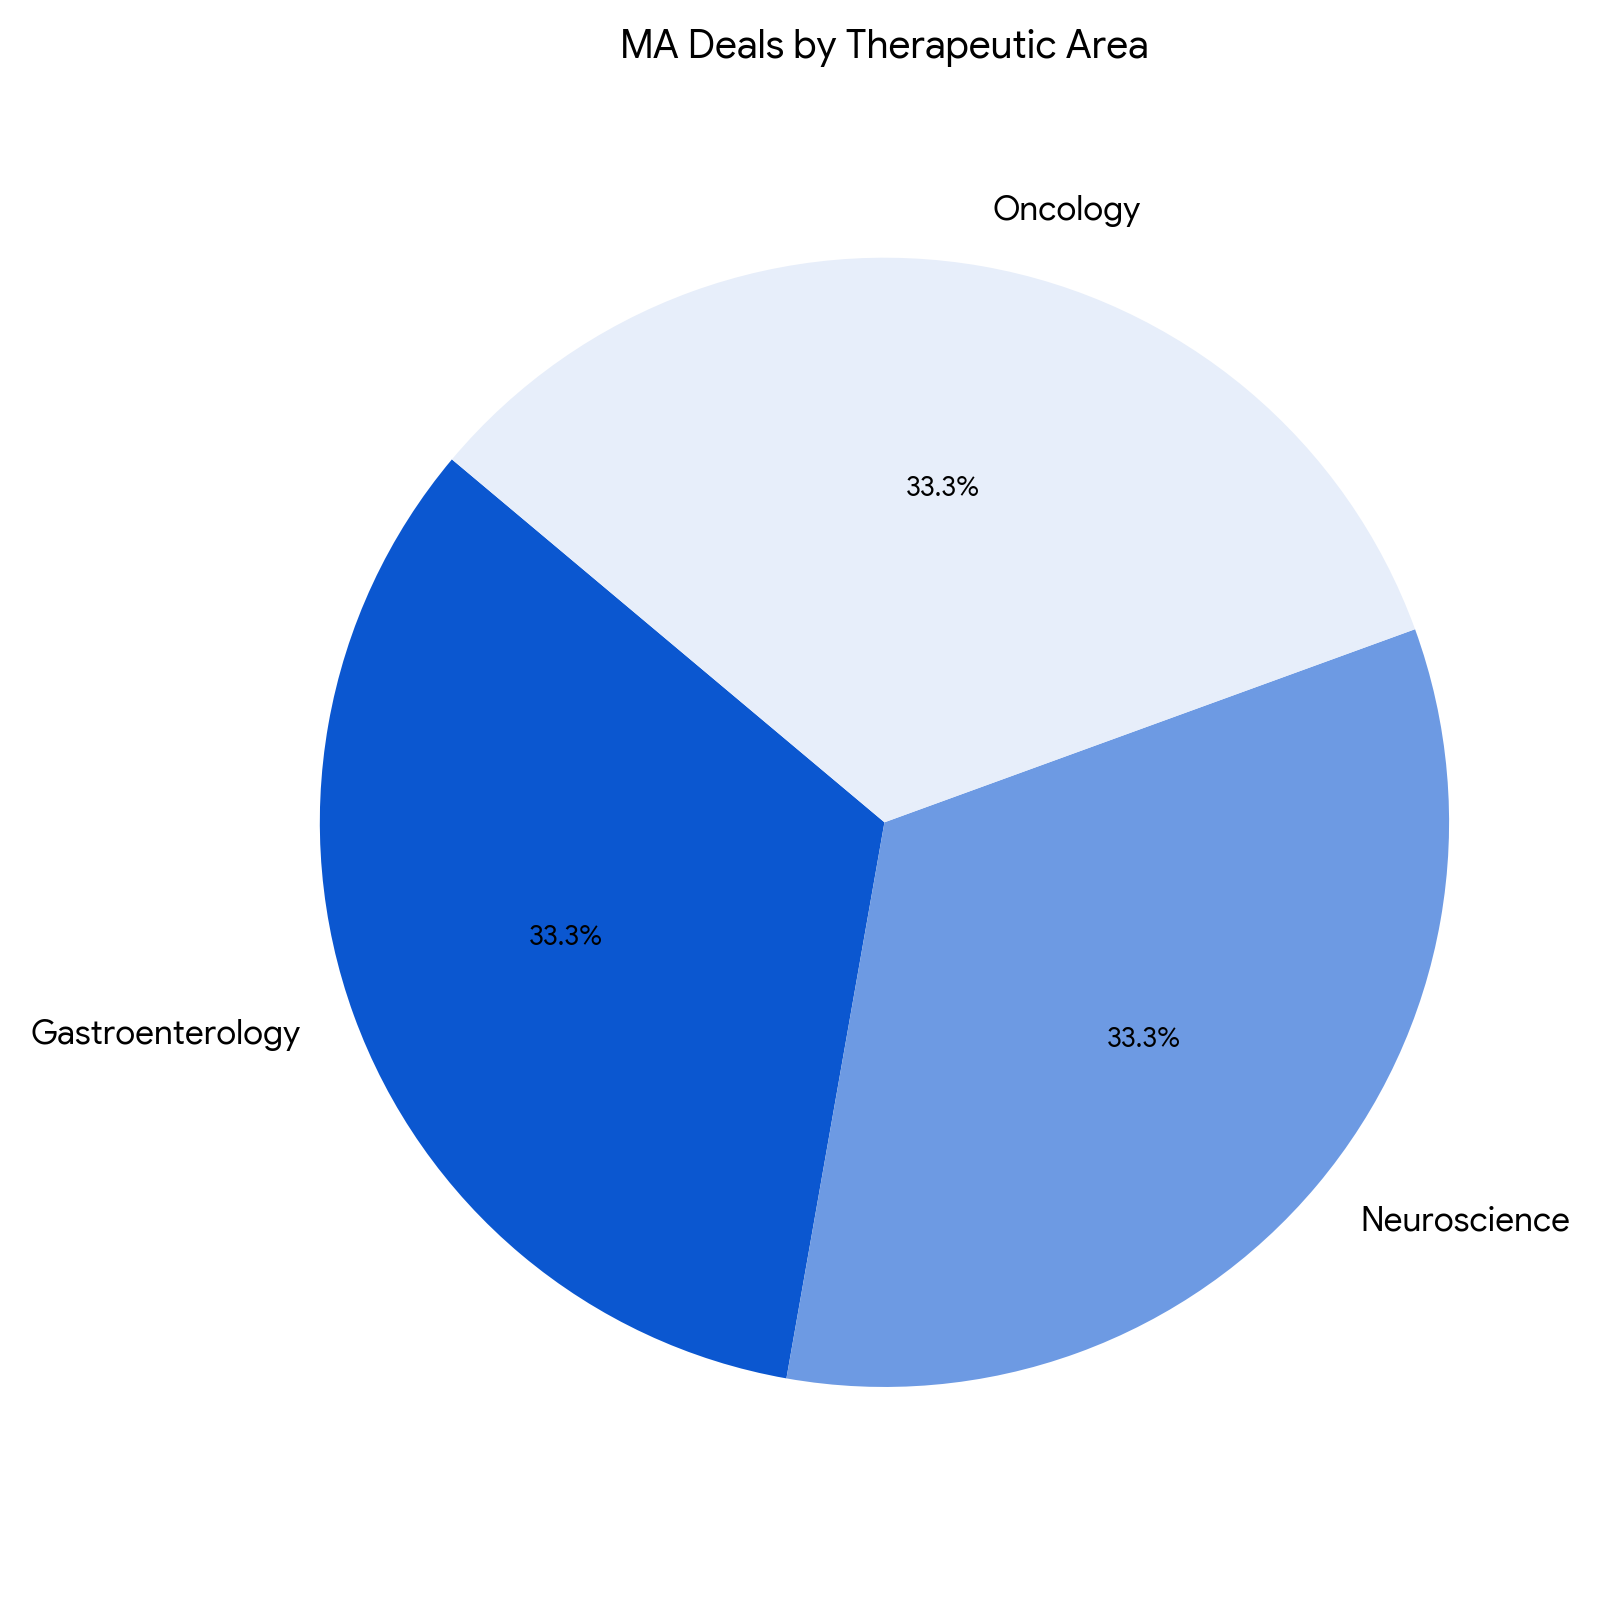

### Text

The pie chart showing the distribution of MA deals by therapeutic area has been generated. The chart displays the proportion of deals in Oncology, Gastroenterology, and Neuroscience, each accounting for 33.3% of the total.



In [22]:
async with live_client.aio.live.connect(model=model, config=config) as session:

  message = "Run some code to generate a python seaborn pie chart by theraperutic area for ma deals"
  print(f"> {message}\n")

  await session.send(input=message, end_of_turn=True)
  await handle_response(session, tool_impl=execute_query)